# SEIR-SEI Model with Python

### Libraries Used

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import csv

### SEIR-SEI Function

In [ ]:
def seir_sei_model(t, y, params):
    """
    Defines the system of ordinary differential equations for the SEIR-SEI model.

    Args:
        t (float): Current time.
        y (array): Current values of the compartments [Sh, Eh, Ih, Rh, Sm, Em, Im].
        params (dict): Dictionary of model parameters.

    Returns:
        array: Derivatives of each compartment with respect to time.
    """
    Sh, Eh, Ih, Rh, Sm, Em, Im = y

    # Extract parameters
    beta_hm = params['beta_hm']  # Human to mosquito transmission rate
    beta_mh = params['beta_mh']  # Mosquito to human transmission rate
    sigma_h = params['sigma_h']  # Rate of exposed humans becoming infectious
    gamma_h = params['gamma_h']  # Rate of infectious humans recovering
    mu_h = params['mu_h']        # Human natural birth/death rate
    sigma_m = params['sigma_m']  # Rate of exposed mosquitoes becoming infectious
    mu_m = params['mu_m']        # Mosquito natural death rate
    A = params['A']              # Mosquito recruitment rate (births)

    # Calculate total populations
    Nh = Sh + Eh + Ih + Rh
    Nm = Sm + Em + Im

    # Ensure no division by zero if populations become zero (unlikely in this model)
    # Add a small epsilon to avoid division by zero if a population becomes exactly zero
    Nh_safe = Nh if Nh > 0 else 1e-6
    Nm_safe = Nm if Nm > 0 else 1e-6

    # --- Human population ODEs ---
    # dSh/dt: Susceptible humans
    dShdt = (mu_h * Nh) - (beta_mh * Sh * Im / Nh_safe) - (mu_h * Sh)

    # dEh/dt: Exposed humans
    dEhdt = (beta_mh * Sh * Im / Nh_safe) - (sigma_h + mu_h) * Eh

    # dIh/dt: Infectious humans
    dIhdt = (sigma_h * Eh) - (gamma_h + mu_h) * Ih

    # dRh/dt: Recovered Humans
    dRhdt = (gamma_h * Ih) - (mu_h * Rh)

    # --- Mosquito population ODEs ---
    # dSm/dt: Susceptible mosquitoes
    dSmdt = A - (beta_hm * Sm * Ih / Nh_safe) - (mu_m * Sm)

    # dEm/dt: Exposed mosquitoes
    dEmdt = (beta_hm * Sm * Ih / Nh_safe) - (mu_m + sigma_m) * Em

    # dIm/dt: Infectious mosquitoes
    dImdt = (sigma_m * Em) - (mu_m * Im)

    return [dShdt, dEhdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt]


### File Reader

In [ ]:
def load_params_from_csv(filepath):
    """
    Loads model parameters and initial conditions from a CSV file.

    Args:
        filepath (str): Path to the CSV file.

    Returns:
        tuple: A tuple containing (initial_conditions_list, parameters_dict, t_end).
    """
    params_data = {}
    with open(filepath, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            try:
                # Convert value to float or int as appropriate
                params_data[row['Parameter']] = float(row['Value'])
            except ValueError:
                # If conversion to float fails, keep as string (though not expected for these params)
                params_data[row['Parameter']] = row['Value']

    # Extract initial conditions
    S_h0 = params_data['S_h0']
    E_h0 = params_data['E_h0']
    I_h0 = params_data['I_h0']
    R_h0 = params_data['R_h0']
    S_m0 = params_data['S_m0']
    E_m0 = params_data['E_m0']
    I_m0 = params_data['I_m0']

    y0 = [S_h0, E_h0, I_h0, R_h0, S_m0, E_m0, I_m0]

    # Extract model parameters
    params = {
        'beta_hm': params_data['beta_hm'],
        'beta_mh': params_data['beta_mh'],
        'sigma_h': params_data['sigma_h'],
        'gamma_h': params_data['gamma_h'],
        'mu_h': params_data['mu_h'],
        'sigma_m': params_data['sigma_m'],
        'mu_m': params_data['mu_m'],
        'A': params_data['A'],
    }

    t_end = int(params_data['t_end']) # Ensure t_end is an integer

    return y0, params, t_end


# Make sure your CSV file (e.g., 'dengue_params.csv') is in the same directory as your script
# or provide the full path to the file.
csv_filepath = 'dengue_case.csv' # Name of the CSV file you save

try:
    y0, params, t_end = load_params_from_csv(csv_filepath)
    print(f"Parameters and initial conditions loaded from {csv_filepath}")
except FileNotFoundError:
    print(f"Error: CSV file '{csv_filepath}' not found.")
    print("Please make sure the 'dengue_params.csv' file is in the same directory as this script.")
    # Fallback to default values if CSV is not found, for demonstration
    N_human_total = 4_340_000
    S_h0 = N_human_total - 100
    E_h0 = 50
    I_h0 = 50
    R_h0 = 0
    N_mosquito_total = N_human_total * 5
    S_m0 = N_mosquito_total - 10
    E_m0 = 5
    I_m0 = 5
    y0 = [S_h0, E_h0, I_h0, R_h0, S_m0, E_m0, I_m0]
    params = {
        'beta_hm': 0.000000005,
        'beta_mh': 0.000000005,
        'sigma_h': 1/7,
        'gamma_h': 1/5,
        'mu_h': 1/(75*365),
        'sigma_m': 1/10,
        'mu_m': 1/10,
        'A': (N_mosquito_total * (1/10)),
    }
    t_end = 365 * 2
    print("Using default parameters for simulation.")

### Solve Intitial Value Problem (solve_ivp)

In [ ]:
t_start = 0
t_span = (t_start, t_end)
t_eval = np.linspace(t_start, t_end, t_end + 1) # Evaluate at each day

solution = solve_ivp(
    fun=seir_sei_model,
    t_span=t_span,
    y0=y0,
    args=(params,),
    t_eval=t_eval,
    method='RK45'
)

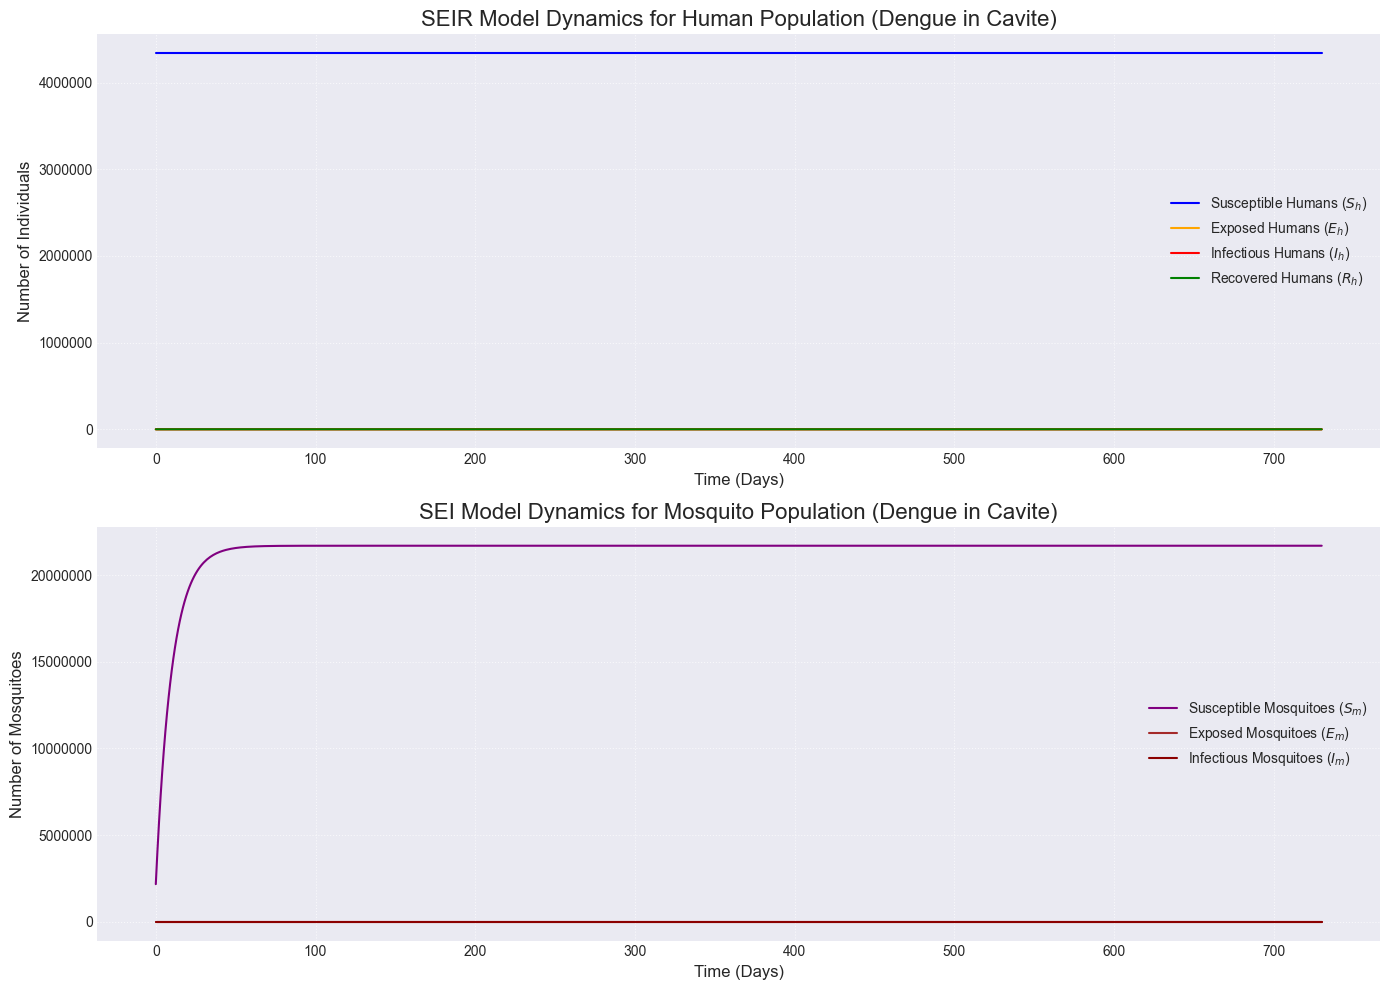

Simulation completed for 730 days.
Initial human infectious cases: 50.0
Peak human infectious cases: 50
Final human infectious cases: 0
Initial mosquito infectious cases: 5.0
Peak mosquito infectious cases: 5
Final mosquito infectious cases: 0


In [ ]:
# Extract results
t = solution.t
Sh, Eh, Ih, Rh, Sm, Em, Im = solution.y

# Plotting results
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 10))

# Plot Human Compartments
plt.subplot(2, 1, 1)
plt.plot(t, Sh, label='Susceptible Humans ($S_h$)', color='blue')
plt.plot(t, Eh, label='Exposed Humans ($E_h$)', color='orange')
plt.plot(t, Ih, label='Infectious Humans ($I_h$)', color='red')
plt.plot(t, Rh, label='Recovered Humans ($R_h$)', color='green')
plt.title('SEIR Model Dynamics for Human Population (Dengue in Cavite)', fontsize=16)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('Number of Individuals', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')

# Plot Mosquito Compartments
plt.subplot(2, 1, 2)
plt.plot(t, Sm, label='Susceptible Mosquitoes ($S_m$)', color='purple')
plt.plot(t, Em, label='Exposed Mosquitoes ($E_m$)', color='brown')
plt.plot(t, Im, label='Infectious Mosquitoes ($I_m$)', color='darkred')
plt.title('SEI Model Dynamics for Mosquito Population (Dengue in Cavite)', fontsize=16)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('Number of Mosquitoes', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

print(f"Simulation completed for {t_end} days.")
print(f"Initial human infectious cases: {y0[2]}") # Ih0 is the 3rd element in y0
print(f"Peak human infectious cases: {int(np.max(Ih))}")
print(f"Final human infectious cases: {int(Ih[-1])}")
print(f"Initial mosquito infectious cases: {y0[6]}") # Im0 is the 7th element in y0
print(f"Peak mosquito infectious cases: {int(np.max(Im))}")
print(f"Final mosquito infectious cases: {int(Im[-1])}")
